In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Basic Situation

In [3]:
train = pd.read_csv('new_df.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,Unnamed: 0,User_ID_x,Product_ID_x,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,...,Max_purchase_price,Quantity_sold,Popular_item,Amount_user_spent,High_spender,User_category,Paid_more_avg,Num_Paid_more_avg,propHigh,luxury
0,0,1000001,P00069042,F,0-17,10,A,2,0,3,...,13716,227,0,334093,0,1,0,19,0.542857,0
1,1,1000017,P00069042,M,51-55,1,C,0,0,3,...,13716,227,0,1425995,0,5,1,85,0.739130,1
2,2,1000023,P00069042,M,36-45,0,B,3,1,3,...,13716,227,0,1670998,0,6,0,60,0.350877,0
3,3,1000030,P00069042,F,36-45,7,C,3,0,3,...,13716,227,0,261584,0,1,0,10,0.322581,0
4,4,1000073,P00069042,M,18-25,4,A,4+,0,3,...,13716,227,0,1428303,0,5,0,70,0.522388,0


In [5]:
train=train.iloc[:,1:]

In [ ]:
train.isnull().sum()
# Based on result, we only have two columns with missing data of 32% missing and 70% missing, suggest to drop based on importance

In [7]:
#deal with missing data
train.fillna(0,inplace=True)

In [8]:
#double check null values
train.isnull().sum().max()

0

In [9]:
# deal with product_id before dummy columns by changing them to int
train['Product_ID_x']=train['Product_ID_x'].str.replace('P','')
train['Product_ID_x']=pd.to_numeric(train['Product_ID_x'])

### Resons to drop Product_category_2 & Product_category_3
    1. Category2 has null value ratio of 32% and Category 3 has 70%. So these are not only the only 2 columns with null, but also the percentage of null with higher ratio than normal
    2. Category 2 is highly correlated with category 1 based on current value (plz check the results in another notebook)

In [31]:
# Drop columns to save only model related columns
feature_=train[['User_ID_x','Product_ID_x','Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','Product_Category_1','User_prod_bought','Quantity_sold','Popular_item']]
target=train.Purchase_price_x

In [32]:
# preprocess whole dataset
feature_ = pd.get_dummies(feature_, prefix_sep='_', drop_first=True)

### Fit XGBoost

In [34]:
import xgboost as xgb
# conver data to DMatrix for xgb
dmatrix= xgb.DMatrix(feature_.values, label=target, missing=np.nan)

In [35]:
untuned_xgb_param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
        'max_depth': 8, 'eta': 0.1, 
        'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 10,
        'metrics':'rmse'}

In [ ]:
untuned_cv_rmse=xgb.cv(dtrain=dmatrix, params=untuned_xgb_param, nfold=5, seed=123, num_boost_round=690 ,early_stopping_rounds=10)
untuned_cv_rmse

In [37]:
untuned_cv_rmse['test-rmse-mean'].mean()

2614.090729163188

In [38]:
# apply untuned hyperparameters to model to fit (better cv results)
xgb_reg=xgb.XGBRegressor(objective='reg:linear', booster='gbtree',
        max_depth= 8, eta= 0.1, 
        subsample=0.8, colsample_bytree=0.8, min_child_weight=10,
        )

In [39]:
xgb_reg.fit(feature_, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=10, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

Text(0, 0.5, 'Feature Importance Score')

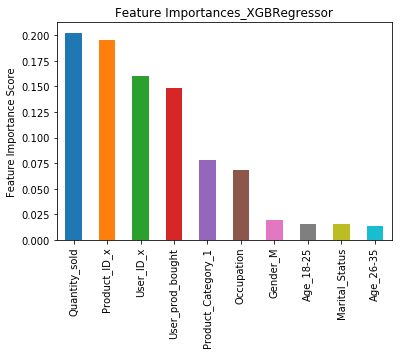

In [44]:
feat_imp = pd.Series(xgb_reg.feature_importances_, index=feature_.columns).sort_values(ascending=False).nlargest(10)
feat_imp.plot(kind='bar', title='Feature Importances_XGBRegressor')
plt.ylabel('Feature Importance Score')

### Summary:
    1. Boosting examples show better results so far 
    If we look at the feature importance, we can find the newly added columns: ’Quatity_sold’ & ‘User_prod_bought’ are good features of high importance to both model and we did well in feature engineering, which serves as reverse engineering that we did well in feature engineering
    2. How to understand this rmse?
    Our target 'Purchase' column has mean value of 9263 and std of 5023, with the maximum value of 24000, 2614 is not a big trouble. 
    3. Possible Reasons:
    3.1 144 out of 3631 is 4% of the whole products have stable selling price, while the other 96% of products have price change which will bring high variance to our prediction. However, based on the private dataset we have, it's hard to set up criteria to drop which data points as outliers. For future reference, we wish to get more clearity of data and make decision to perform better data cleaning 